In [2]:
# =========================
# Bloque 1: Imports y config
# =========================
import os
import random
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as T

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

# ---- Ruta a la carpeta de imágenes ORIGINALES ----
# AJUSTA ESTA RUTA A TU PC
ROOT_DIR = Path(r"C:\Users\i21319\Desktop\DeepProyecto\Fruits Original")

assert ROOT_DIR.exists(), f"No se encontró la ruta: {ROOT_DIR}"

# ---- Dispositivo ----
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Usando dispositivo:", DEVICE)

# ---- Semilla para reproducibilidad ----
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)


Usando dispositivo: cuda


In [3]:
# ============================================
# Bloque 2: Construir tabla de imágenes + split
# ============================================

def build_index(root: Path):
    """
    Recorre Fruits Original y construye una tabla:
    columns = [path, fruit, status, class_name]
    donde class_name = 'Apple_Fresh', etc.
    """
    registros = []
    exts = {".jpg", ".jpeg", ".png", ".bmp", ".JPG", ".JPEG", ".PNG", ".BMP"}
    
    for fruit_dir in sorted(root.iterdir()):
        if not fruit_dir.is_dir():
            continue
        fruit = fruit_dir.name  # Apple, Banana, ...
        
        for status_dir in sorted(fruit_dir.iterdir()):
            if not status_dir.is_dir():
                continue
            status = status_dir.name  # Fresh, Rotten, Formalin-mixed, ...
            class_name = f"{fruit}_{status}"
            
            for img_path in status_dir.iterdir():
                if img_path.suffix in exts:
                    registros.append({
                        "path": str(img_path),
                        "fruit": fruit,
                        "status": status,
                        "class_name": class_name,
                    })
    return pd.DataFrame(registros)

df = build_index(ROOT_DIR)
print("Total de imágenes:", len(df))
df.head()


Total de imágenes: 10154


,path,fruit,status,class_name
0,C:\Users\i21319\Desktop\DeepProyecto\Fruits Or...,Apple,Formalin-mixed,Apple_Formalin-mixed
1,C:\Users\i21319\Desktop\DeepProyecto\Fruits Or...,Apple,Formalin-mixed,Apple_Formalin-mixed
2,C:\Users\i21319\Desktop\DeepProyecto\Fruits Or...,Apple,Formalin-mixed,Apple_Formalin-mixed
3,C:\Users\i21319\Desktop\DeepProyecto\Fruits Or...,Apple,Formalin-mixed,Apple_Formalin-mixed
4,C:\Users\i21319\Desktop\DeepProyecto\Fruits Or...,Apple,Formalin-mixed,Apple_Formalin-mixed


In [4]:
# Ver cuántas imágenes hay por clase
df["class_name"].value_counts()


class_name
Grape_Fresh              770
Apple_Fresh              765
Mango_Fresh              763
Orange_Fresh             753
Banana_Fresh             749
Banana_Formalin-mixed    660
Orange_Rotten            656
Orange_Formalin-mixed    647
Apple_Formalin-mixed     643
Banana_Rotten            632
Apple_Rotten             630
Mango_Rotten             630
Grape_Rotten             630
Mango_Formalin-mixed     616
Grape_Formalin-mixed     610
Name: count, dtype: int64

In [5]:
# Mapear class_name -> índice (0..num_classes-1)
class_names = sorted(df["class_name"].unique())
class_to_idx = {name: i for i, name in enumerate(class_names)}
idx_to_class = {i: name for name, i in class_to_idx.items()}

df["label"] = df["class_name"].map(class_to_idx)

num_classes = len(class_names)
print("Número de clases:", num_classes)
print("Clases:", class_names)


Número de clases: 15
Clases: ['Apple_Formalin-mixed', 'Apple_Fresh', 'Apple_Rotten', 'Banana_Formalin-mixed', 'Banana_Fresh', 'Banana_Rotten', 'Grape_Formalin-mixed', 'Grape_Fresh', 'Grape_Rotten', 'Mango_Formalin-mixed', 'Mango_Fresh', 'Mango_Rotten', 'Orange_Formalin-mixed', 'Orange_Fresh', 'Orange_Rotten']


In [6]:
# Split estratificado 70/15/15
train_df, temp_df = train_test_split(
    df,
    test_size=0.30,
    stratify=df["label"],
    random_state=42,
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,        # de ese 30%, la mitad → 15% total
    stratify=temp_df["label"],
    random_state=42,
)

len(train_df), len(val_df), len(test_df)


(7107, 1523, 1524)

In [7]:
# Comprobar distribución de clases en cada split (opcional)
print("Train:")
print(train_df["class_name"].value_counts(normalize=True).round(3))

print("\nVal:")
print(val_df["class_name"].value_counts(normalize=True).round(3))

print("\nTest:")
print(test_df["class_name"].value_counts(normalize=True).round(3))


Train:
class_name
Grape_Fresh              0.076
Apple_Fresh              0.075
Mango_Fresh              0.075
Orange_Fresh             0.074
Banana_Fresh             0.074
Banana_Formalin-mixed    0.065
Orange_Rotten            0.065
Orange_Formalin-mixed    0.064
Apple_Formalin-mixed     0.063
Banana_Rotten            0.062
Apple_Rotten             0.062
Grape_Rotten             0.062
Mango_Rotten             0.062
Mango_Formalin-mixed     0.061
Grape_Formalin-mixed     0.060
Name: proportion, dtype: float64

Val:
class_name
Grape_Fresh              0.076
Apple_Fresh              0.075
Mango_Fresh              0.075
Orange_Fresh             0.074
Banana_Fresh             0.074
Banana_Formalin-mixed    0.065
Orange_Rotten            0.064
Orange_Formalin-mixed    0.064
Apple_Formalin-mixed     0.063
Mango_Rotten             0.062
Banana_Rotten            0.062
Grape_Rotten             0.062
Apple_Rotten             0.062
Mango_Formalin-mixed     0.061
Grape_Formalin-mixed     0.060
Na

In [8]:
# ===========================================
# Bloque 3: Calcular mean/std y definir transforms
# ===========================================

def compute_mean_std(df_subset, sample_size=1000):
    """
    Calcula mean y std por canal a partir de una muestra de imágenes.
    sample_size: cuántas imágenes usar (máx = tamaño del subset).
    """
    paths = df_subset["path"].tolist()
    if sample_size is not None and sample_size < len(paths):
        paths = random.sample(paths, sample_size)
    
    means = []
    stds = []
    
    basic_transform = T.Compose([
        T.Resize((256, 256)),
        T.ToTensor(),
    ])
    
    for p in paths:
        img = Image.open(p).convert("RGB")
        x = basic_transform(img)  # [3,H,W] en [0,1]
        means.append(x.mean(dim=(1, 2)))  # por canal
        stds.append(x.std(dim=(1, 2)))
    
    mean = torch.stack(means).mean(dim=0)
    std = torch.stack(stds).mean(dim=0)
    return mean.tolist(), std.tolist()

mean, std = compute_mean_std(train_df, sample_size=1000)
print("Mean:", mean)
print("Std:", std)


Mean: [0.6631208062171936, 0.6321953535079956, 0.5735348463058472]
Std: [0.12329615652561188, 0.13154181838035583, 0.21672791242599487]


In [9]:
# Transforms: augmentación en train, solo reescalar+normalizar en val/test

train_transform = T.Compose([
    T.Resize((256, 256)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
])

val_test_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
])


In [ ]:
# ==============================
# Bloque 4: Dataset + DataLoader
# ==============================

class FruitDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["path"]
        label = int(row["label"])
        
        img = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)
        return img, label

BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataset = FruitDataset(train_df, transform=train_transform)
val_dataset   = FruitDataset(val_df,   transform=val_test_transform)
test_dataset  = FruitDataset(test_df,  transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

len(train_dataset), len(val_dataset), len(test_dataset)


(7107, 1523, 1524)

In [11]:
# ============================
# Bloque 5: Modelo CNN baseline
# ============================

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.features = nn.Sequential(
            # Bloque 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 256 -> 128

            # Bloque 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 128 -> 64

            # Bloque 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 64 -> 32

            # Bloque 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),   # 32 -> 16
        )
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = SimpleCNN(num_classes=num_classes).to(DEVICE)
print(model)


SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): BatchNorm2d(256, eps=1e-05, momentum=0.1, af

In [12]:
# ======================================
# Bloque 6: Entrenamiento + validación
# ======================================

LR = 1e-3
EPOCHS = 20

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for xb, yb in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        
        optimizer.zero_grad()
        logits = model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * xb.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            yb = yb.to(device)
            
            logits = model(xb)
            loss = criterion(logits, yb)
            
            running_loss += loss.item() * xb.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == yb).sum().item()
            total += yb.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

best_val_acc = 0.0
best_state_dict = None
history = []

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, DEVICE)
    val_loss, val_acc = evaluate(model, val_loader, criterion, DEVICE)
    
    history.append({
        "epoch": epoch,
        "train_loss": train_loss,
        "train_acc": train_acc,
        "val_loss": val_loss,
        "val_acc": val_acc,
    })
    
    print(f"Época {epoch:02d} | "
          f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
    
    # Guardar el mejor modelo según accuracy de validación
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state_dict = model.state_dict()

print("\nMejor accuracy en validación:", best_val_acc)

# Cargar el mejor estado antes de evaluar en test
if best_state_dict is not None:
    model.load_state_dict(best_state_dict)


Época 01 | Train Loss: 1.6234 Acc: 0.4100 | Val Loss: 1.3106 Acc: 0.4787
Época 02 | Train Loss: 1.0871 Acc: 0.5580 | Val Loss: 0.8597 Acc: 0.6402
Época 03 | Train Loss: 0.9246 Acc: 0.6135 | Val Loss: 0.8159 Acc: 0.6573
Época 04 | Train Loss: 0.8595 Acc: 0.6475 | Val Loss: 0.6880 Acc: 0.7032
Época 05 | Train Loss: 0.8233 Acc: 0.6560 | Val Loss: 0.5947 Acc: 0.7400
Época 06 | Train Loss: 0.7463 Acc: 0.6916 | Val Loss: 0.6681 Acc: 0.7249
Época 07 | Train Loss: 0.7036 Acc: 0.7020 | Val Loss: 0.5740 Acc: 0.7420
Época 08 | Train Loss: 0.7297 Acc: 0.6889 | Val Loss: 0.5709 Acc: 0.7682
Época 09 | Train Loss: 0.6691 Acc: 0.7169 | Val Loss: 1.3226 Acc: 0.6763
Época 10 | Train Loss: 0.6976 Acc: 0.7045 | Val Loss: 0.5009 Acc: 0.7892
Época 11 | Train Loss: 0.6456 Acc: 0.7245 | Val Loss: 0.4824 Acc: 0.8004
Época 12 | Train Loss: 0.6587 Acc: 0.7189 | Val Loss: 0.4934 Acc: 0.7971
Época 13 | Train Loss: 0.5981 Acc: 0.7462 | Val Loss: 0.4689 Acc: 0.8024
Época 14 | Train Loss: 0.6063 Acc: 0.7421 | Val Los

In [13]:
# ==================================================
# Bloque 7: Evaluación en test + métricas finales
# ==================================================

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(DEVICE)
        logits = model(xb)
        preds = logits.argmax(dim=1).cpu().numpy()
        
        all_preds.extend(preds)
        all_labels.extend(yb.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# ---- Reporte de clasificación ----
print("Reporte de clasificación (TEST):\n")
print(classification_report(
    all_labels,
    all_preds,
    target_names=[idx_to_class[i] for i in range(num_classes)],
    digits=3
))


Reporte de clasificación (TEST):

                       precision    recall  f1-score   support

 Apple_Formalin-mixed      0.636     0.505     0.563        97
          Apple_Fresh      0.547     0.557     0.552       115
         Apple_Rotten      0.750     0.734     0.742        94
Banana_Formalin-mixed      0.780     1.000     0.876        99
         Banana_Fresh      0.935     0.770     0.845       113
        Banana_Rotten      0.978     0.958     0.968        95
 Grape_Formalin-mixed      0.929     0.857     0.891        91
          Grape_Fresh      0.899     1.000     0.947       116
         Grape_Rotten      0.943     0.883     0.912        94
 Mango_Formalin-mixed      0.872     0.891     0.882        92
          Mango_Fresh      0.897     0.904     0.900       115
         Mango_Rotten      0.989     0.915     0.950        94
Orange_Formalin-mixed      0.686     0.608     0.645        97
         Orange_Fresh      0.672     0.779     0.721       113
        Orange_Rotte

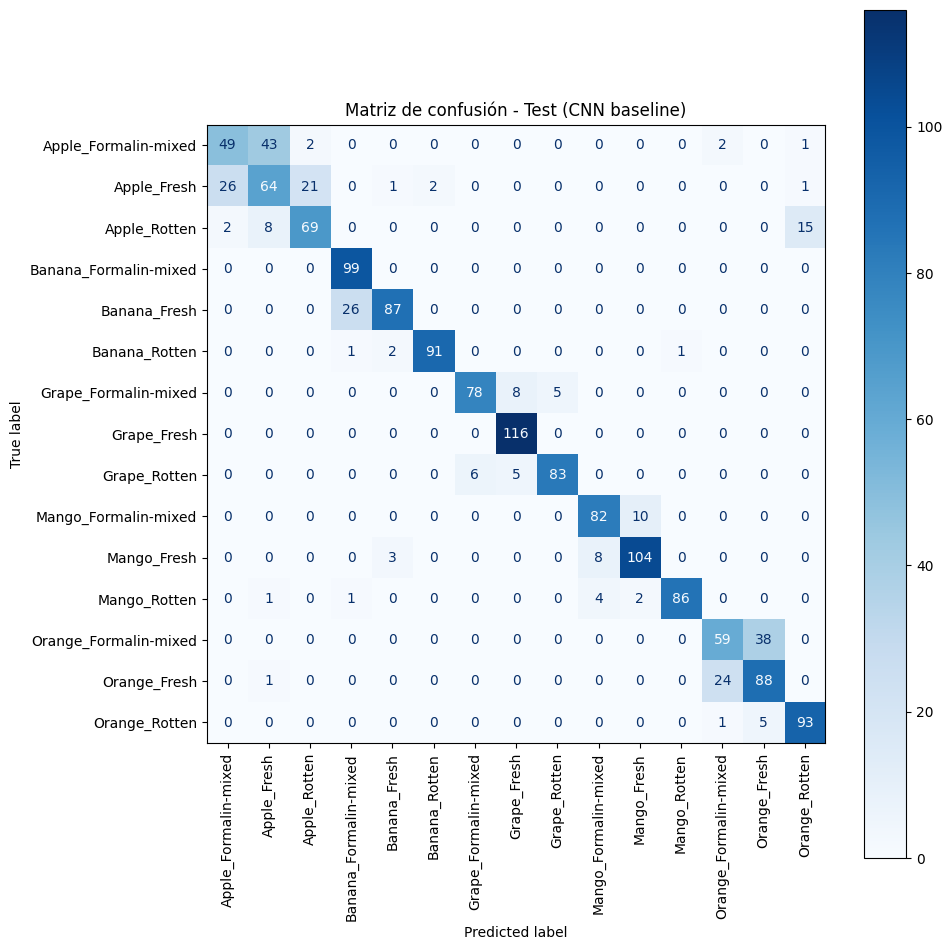

In [14]:
# ---- Matriz de confusión ----
cm = confusion_matrix(all_labels, all_preds)
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[idx_to_class[i] for i in range(num_classes)]
)
disp.plot(xticks_rotation=90, ax=ax, cmap="Blues", colorbar=True)
plt.title("Matriz de confusión - Test (CNN baseline)")
plt.tight_layout()
plt.show()
